In [1]:
!pip install -qq transformers

     |████████████████████████████████| 3.5 MB 11.4 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 48.2 MB/s 
     |████████████████████████████████| 6.8 MB 41.2 MB/s 
     |████████████████████████████████| 895 kB 44.6 MB/s 


In [6]:
import os
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from transformers import BertForSequenceClassification
import torch
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments, BertConfig

In [7]:
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
#loading the data
reviews = pd.read_csv("IMDB_reviews.csv")
print(reviews.shape)

reviews.head()

(50000, 2)


,review,sentiment
0,"Someone(or, something thing..)is leaving punct...",positive
1,Beginning with the poster (featuring only Morg...,negative
2,This movie is one of the most awful movies eve...,negative
3,Generally political messages are done on telev...,negative
4,I'm surprised at the comments from posters sta...,positive


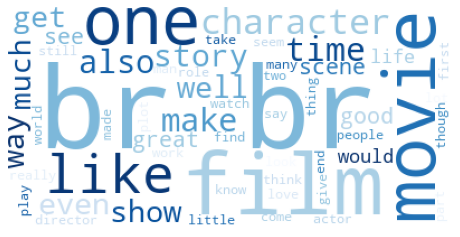

In [10]:
from wordcloud import WordCloud

def plot_wordcloud(review, cmap):
    fig, ax = plt.subplots(figsize=(8, 6))
    wc = WordCloud(max_words = 1000, background_color ='white', stopwords = stopwords, 
                   min_font_size = 10, colormap=cmap)
    wc = wc.generate(review)
    plt.axis('off')
    plt.imshow(wc)

# word cloud on positve reviews
pos_rev = ' '.join(reviews[reviews['sentiment']=='positive']['review'].to_list()[:10000])
plot_wordcloud(pos_rev, 'Blues')

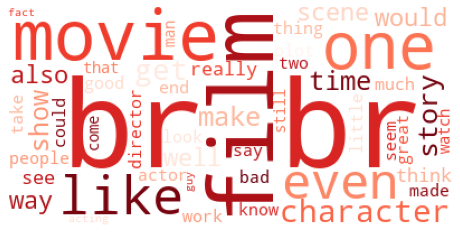

In [11]:
# word cloud on positve reviews
neg_rev = ' '.join(reviews[reviews['sentiment']=='negative']['review'].to_list()[:10000])
plot_wordcloud(neg_rev, 'Reds')

In [12]:
#Convert categorical data into numerical 
# 1 for "positive", 0 for "negative"
le = LabelEncoder()
label = le.fit_transform(reviews['sentiment'])
reviews['label'] = label

reviews = reviews.drop('sentiment', 1)
reviews.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


,review,label
0,"Someone(or, something thing..)is leaving punct...",1
1,Beginning with the poster (featuring only Morg...,0
2,This movie is one of the most awful movies eve...,0
3,Generally political messages are done on telev...,0
4,I'm surprised at the comments from posters sta...,1


label
0    25000
1    25000
dtype: int64


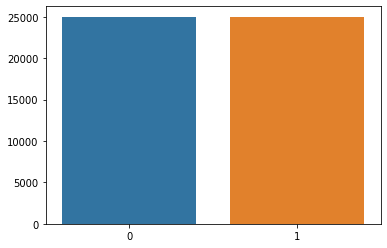

In [13]:
#analysing labels
print(reviews.groupby(['label']).size())

dd = pd.Series(reviews['label']).value_counts()
sns.barplot(x=np.array(['0','1']),y= dd.values)
plt.show()

In [14]:
#split data into train set, validation set and test set

train_set = reviews[0:20000]
valid_set = reviews[40000:42000]
test_set  = reviews[48000:50000]


print(len(train_set))
print(len(valid_set))
print(len(test_set))

20000
2000
2000


**Create dataset and define parameters for Bert model**

In [15]:
MAX_LEN = 200

In [16]:
# loads the data and does the tokenization
class Dataset(torch.utils.data.Dataset):

    def __init__(self, reviews, sentiments, tokenizer):
        self.reviews    = reviews
        self.sentiments = sentiments
        self.tokenizer  = tokenizer
        self.max_len    = MAX_LEN
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, index):
        review = str(self.reviews[index])
        sentiments = self.sentiments[index]

        encoded_review = self.tokenizer.encode_plus(
            review,
            add_special_tokens    = True,
            max_length            = MAX_LEN, #Bert = 512 if self.max_len (the maximum number of tokens that BERT accepts as input)
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = "pt",
            padding               = "max_length",
            truncation            = True)

        return { 'input_ids': encoded_review['input_ids'][0],
            'attention_mask': encoded_review['attention_mask'][0],
            'labels': torch.tensor(sentiments, dtype=torch.long)}


In [17]:
# Load the tokenizer for the BERT model.
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [18]:
# Create Dataset objects for train/validation sets.
train_set_dataset = Dataset(
    reviews    = train_set.review.tolist(),
    sentiments = train_set.label.tolist(),
    tokenizer  = tokenizer)

valid_set_dataset = Dataset(
    reviews    = valid_set.review.tolist(),
    sentiments = valid_set.label.tolist(),
    tokenizer  = tokenizer)

test_set_dataset = Dataset(
    reviews    = test_set.review.tolist(),
    sentiments = test_set.label.tolist(),
    tokenizer  = tokenizer)


**SET THE MODEL**

In [19]:
# 24-layer model with 330M parameters
model = BertForSequenceClassification.from_pretrained("bert-large-uncased")

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [20]:
#setting requires_grad attribute to zero, not optimizing these weights
# Freeze BERT except the pooler layer

for name, param in model.bert.named_parameters():
    if not name.startswith('pooler'):
        param.requires_grad = False

#model.bert.parameters

In [21]:
def compute_metrics(pred):
    # sklearn library, metrics
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    
    return { 'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

#define training arguments
training_args = TrainingArguments(
    output_dir                  = "./Model_checkpoint",
    num_train_epochs            = 3,
    per_device_train_batch_size = 128,
    per_device_eval_batch_size  = 32,
    warmup_steps                = 500,
    weight_decay                = 0.01,
    save_strategy               = "epoch",
    evaluation_strategy         = "steps")

**TRAIND AND EVALUATE THE MODEL using trainer.train**

In [22]:
#set trainer function for training process
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = valid_set_dataset,
    compute_metrics = compute_metrics)

# train the model 
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20000
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 471


Step,Training Loss,Validation Loss


Saving model checkpoint to ./Model_checkpoint/checkpoint-157
Configuration saved in ./Model_checkpoint/checkpoint-157/config.json
Model weights saved in ./Model_checkpoint/checkpoint-157/pytorch_model.bin
Saving model checkpoint to ./Model_checkpoint/checkpoint-314
Configuration saved in ./Model_checkpoint/checkpoint-314/config.json
Model weights saved in ./Model_checkpoint/checkpoint-314/pytorch_model.bin
Saving model checkpoint to ./Model_checkpoint/checkpoint-471
Configuration saved in ./Model_checkpoint/checkpoint-471/config.json
Model weights saved in ./Model_checkpoint/checkpoint-471/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=471, training_loss=0.6377936685161226, metrics={'train_runtime': 4677.3242, 'train_samples_per_second': 12.828, 'train_steps_per_second': 0.101, 'total_flos': 2.1842141328e+16, 'train_loss': 0.6377936685161226, 'epoch': 3.0})

**MAKE PREDICTIONS USING TEST SET**

In [23]:
# Load the checkpoint
model = BertForSequenceClassification.from_pretrained("./Model_checkpoint/checkpoint-471")

#define training arguments for predictions
training_args = TrainingArguments(
    output_dir = "./Model_checkpoint",
    do_predict = True)

#set trainer function for prediction process
trainer = Trainer(
    model           = model,
    args            = training_args,
    compute_metrics =compute_metrics)

# test the model 
trainer.predict(test_set_dataset)

loading configuration file ./Model_checkpoint/checkpoint-471/config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file ./Model_checkpoint/checkpoint-471/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the wei

PredictionOutput(predictions=array([[-0.03300462, -0.6914329 ],
       [ 0.47961634, -1.1289766 ],
       [-0.58509177,  0.01241786],
       ...,
       [-1.4805917 ,  0.5712282 ],
       [ 0.09958365, -0.7683601 ],
       [-0.6174902 , -0.1267065 ]], dtype=float32), label_ids=array([0, 0, 1, ..., 1, 0, 0]), metrics={'test_loss': 0.4849175214767456, 'test_accuracy': 0.7725, 'test_f1': 0.7719298245614036, 'test_precision': 0.7482993197278912, 'test_recall': 0.7971014492753623, 'test_runtime': 160.8617, 'test_samples_per_second': 12.433, 'test_steps_per_second': 1.554})